<a href="https://colab.research.google.com/github/narfdf999/Arquitectura/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Reshape, Conv2DTranspose
from keras.models import Model ,Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K



In [0]:
#Load Dataset
def load_data():
  path = '/content/drive/My Drive/1260_mercator'
  x_train = np.load('/content/drive/My Drive/1260_mercator/01a.npy')

  for filename in glob.glob(os.path.join(path, '*.npy')):
    if(filename != '/content/drive/My Drive/1260_mercator/01a.npy'):
      print(filename)
      aux=np.load(filename)
      print(x_train.shape)
      print(aux.shape)
      x_train=np.concatenate((x_train,aux),axis = 0)  

  return x_train

x_train = load_data()
print(x_train)

In [0]:
np.save('/content/drive/My Drive/1260_mercator/mercator_total.npy',x_train)

In [0]:
#Add Noise to our MNNIST Dataset by sampling random values from Gaussian distribution by using np.random.normal() and adding it to our original images to change pixel values

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
print(x_train_noisy)



In [0]:
np.save('/content/drive/My Drive/1260_mercator/mercator_total_noisy1.npy',x_train_noisy)

In [0]:
x_train = np.load('/content/drive/My Drive/1260_mercator/mercator_total.npy')

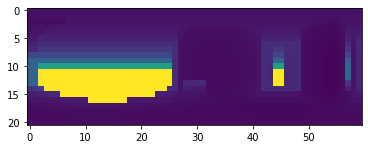

In [7]:
plt.imshow(x_train[120],vmin=-1,vmax=1)

In [18]:
print(x_train[1].shape)

(21, 60)


In [0]:
def adam_optimizer():
  return Adam(lr=0.0002, beta_1=0.5)


In [24]:
# input matriz (21,60)
# output array 128
def create_encoder():
  
    encoder=Sequential()

    encoder.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),input_shape=(21,60,1), activation='tanh',name='e_conv2d_1'))
    encoder.add(BatchNormalization())
    #encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),name='e_maxpool_1'))
    
    encoder.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='tanh',name='e_conv2d_2'))
    encoder.add(BatchNormalization())
    #encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),name='e_maxpool_2'))
    
    encoder.add(Flatten())
    encoder.add(Dense(units=128, activation='tanh'))
    encoder.add(BatchNormalization())
    
    encoder.compile(loss='mse', optimizer=adam_optimizer())
    encoder.name='encoder'
    return encoder
encoder = create_encoder()
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_conv2d_1 (Conv2D)          (None, 17, 56, 32)        832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 17, 56, 32)        128       
_________________________________________________________________
e_maxpool_1 (MaxPooling2D)   (None, 16, 55, 32)        0         
_________________________________________________________________
e_conv2d_2 (Conv2D)          (None, 12, 51, 32)        25632     
_________________________________________________________________
batch_normalization_8 (Batch (None, 12, 51, 32)        128       
_________________________________________________________________
e_maxpool_2 (MaxPooling2D)   (None, 11, 50, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 17600)             0   

In [34]:
# input array 128
# output matriz (21,60)
def create_decoder():
  decoder=Sequential()

  decoder.add(Dense(128 * 5 * 3, input_dim=128, name='dense'))
  decoder.add(Reshape((3, 5, 128), name='reshape'))

  decoder.add(Conv2DTranspose(64, (5,5), strides=(7,3), padding='same', name='conv2dt_1'))
  decoder.add(Conv2DTranspose(1, (5,5), strides=(1,4), padding='same', name='conv2dt_2'))

  decoder.compile(loss='mse', optimizer=adam_optimizer())
  decoder.name='decoder'
  return decoder
decoder = create_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1920)              247680    
_________________________________________________________________
reshape (Reshape)            (None, 3, 5, 128)         0         
_________________________________________________________________
conv2dt_1 (Conv2DTranspose)  (None, 21, 15, 64)        204864    
_________________________________________________________________
conv2dt_2 (Conv2DTranspose)  (None, 21, 60, 1)         1601      
Total params: 454,145
Trainable params: 454,145
Non-trainable params: 0
_________________________________________________________________


In [35]:
def autoencoder(encoder,decoder):
  autoencoder_input = Input(shape=(21,60,1))
  x = encoder(autoencoder_input)
  autoencoder_output=decoder(x)
  autoencoder = Model(inputs=[autoencoder_input], outputs=autoencoder_output)
  autoencoder.compile(loss='mse', optimizer='adam')
  autoencoder.name='autoencoder'
  return autoencoder

autoencoder=autoencoder(encoder,decoder)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 60, 1)         0         
_________________________________________________________________
encoder (Sequential)         (None, 128)               2280160   
_________________________________________________________________
decoder (Sequential)         (None, 21, 60, 1)         454145    
Total params: 2,734,305
Trainable params: 2,733,921
Non-trainable params: 384
_________________________________________________________________


In [0]:
def train(x_train, y_train, epochs, batch_size, sample_intervals):
  for epoch in range(epochs):
    #entrenar el decoder
    latente = encoder.predict(x_train)
    decoder.fit(latente,y_train,batch_size, epochs=1)
    #entrenar el encoder
    encoder.fit(x_train,latente,batch_size,epochs=1)
    #guardar modelos y dibujar cada 20 epocas
    encoder.save("encoder_prueba.h5")
    decoder.save("decoder_prueba.h5")
    print("Saved model to disk")
    


In [0]:
autoencoder.fit(x_train_noisy, x_train,epochs=100,batch_size=128,shuffle=True,validation_data=(x_test_noisy, x_test),)

ValueError: ignored